<a href="https://colab.research.google.com/github/src-d/engine-tour/blob/master/source%7Bd%7D_Engine_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# source{d} Engine demo


### a quick set-up

First of all let's define a couple of functions to make the code coming up simpler.
This uses `pymysql` a popular Python SQL connector, and numpy + matplotlib to show the
power and flexibility of the Engine.


**NOTE:** This will connect to an engine running on `localhost`, in order to run it you can download the source{d} Engine from sourced.tech/engine and follow the quick-start instructions.

In [0]:
# first some extra packages we're gonna need
!pip3 install pymysql coloredlogs wordcloud

You might need to modify the value of `port` in the following piece of code.

In [0]:
host = 'localhost'
user = 'root'
passwd = ''

In [0]:
from matplotlib import pyplot as plt
import numpy as np
import pymysql
import time
import coloredlogs, logging

coloredlogs.install(level='DEBUG')

def run(query):
    conn = pymysql.connect(host=host, port=3306, user=user, passwd=passwd, db='mysql')
    start = time.time()

    cursor = conn.cursor()
    cursor.execute(query)

    end = time.time()
    logging.debug("done in %.2f seconds" % (end - start))
    return cursor

def run_one(query):
    return run(query).fetchone()

def run_and_print(query):
    for row in run(query):
        print(*row)

### The simplest query

So the source{d} Engine provides a way to explore git repositories with a SQL interface.
But what repositories are we analyzing?

Let's simply check the `repositories` table to answer the question.

In [17]:
(count) = run_one("""
    SELECT COUNT(*) FROM repositories;
""")
print('Found %d repositories' % (count))
print('\nFirst ten alphabetically:')
run_and_print("""
    SELECT * FROM repositories ORDER BY repository_id LIMIT 10;
""")

2018-11-08 22:37:04 b17e83b6851d root[66] DEBUG done in 0.04 seconds
2018-11-08 22:37:05 b17e83b6851d root[66] DEBUG done in 0.04 seconds


Found 96 repositories

First ten alphabetically:
ExoPlayer
WebFundamentals
androguard
auto
benchmark
blockly-android
boringssl
breakpad
brotli
cadvisor


Great, so we have a `repositories` table contains the identifiers of the repositories to analyze.

But what other tables do we have? Well, let's use SQL for this!

In [0]:
run_and_print("""
    SHOW TABLES;
""")

2018-11-07 22:00:21 80ee19d41ee3 root[63] DEBUG done in 0.04 seconds


blobs
commit_blobs
commit_files
commit_trees
commits
files
ref_commits
refs
remotes
repositories
tree_entries


These tables map the data model of git into a series of relational tables.

For more details on the schema, check out [this document](https://github.com/src-d/gitbase/blob/master/docs/using-gitbase/schema.md).

### Understanding commit velocity

Imagine you need to answer the following question: are we committing more often than a year ago? What about the growth rate of that number of commits?

Well, let's simply count the number of commits per year/month and plot it.

querying data... (should take around 30 seconds)


2018-11-07 22:00:32 80ee19d41ee3 root[63] DEBUG done in 9.87 seconds


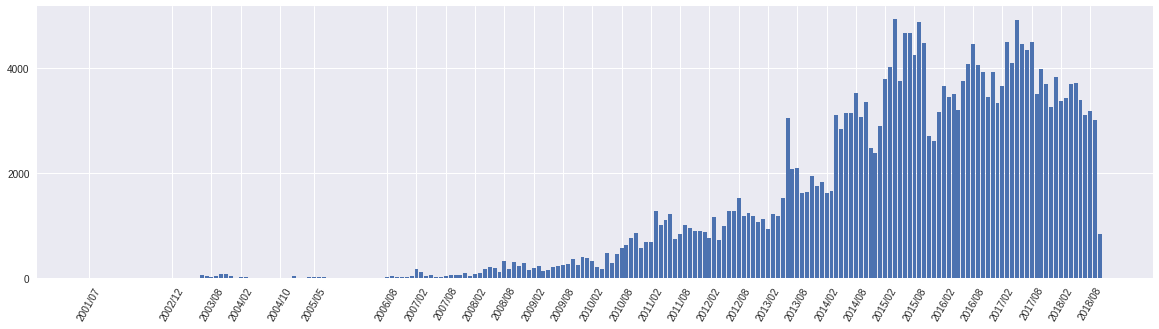

In [0]:
import datetime as dt
 
print('querying data... (should take around 30 seconds)')

rows = run("""
SELECT year, month, count(*) as n
FROM (
  SELECT YEAR(commit_author_when) as year, MONTH(commit_author_when) as month
  FROM commits
) as t
GROUP BY year, month
ORDER BY year, month;
""")

years, months, counts = zip(*rows)
labels = ['%04d/%02d' % (year, month) for (year, month) in zip(years, months)]
dates = [12 * year + month for (year, month) in zip(years, months)]

plt.figure(figsize=(20,5))
plt.locator_params(nbins=4)
plt.bar(dates, counts)
plt.xticks(dates[::6], labels[::6], rotation=60)

plt.show()

Great, so this allows us to see how the number of commits evolved over time. But what if we want to separate by repositories?

It shouldn't be hard, with the power of SQL!

In [0]:
print('querying data... (can take up to 30 seconds)')

rows = run("""
    SELECT repository_id, year, count(*) as n
    FROM (
      SELECT repository_id, YEAR(commit_author_when) as year
      FROM commits
    ) as t
    GROUP BY year, repository_id
    ORDER BY year
""")

data = {}
for (repo, year, count) in rows:
    d = data.get(repo, {})
    d[year] = count
    data[repo] = d

repos = [repo for repo in data]
years = list(set.union(*[set(data[repo].keys()) for repo in data]))
counts = [[data[repo].get(year, 0) for year in years] for repo in repos]

querying data... (can take up to 30 seconds)


2018-11-07 22:00:47 80ee19d41ee3 root[63] DEBUG done in 9.87 seconds


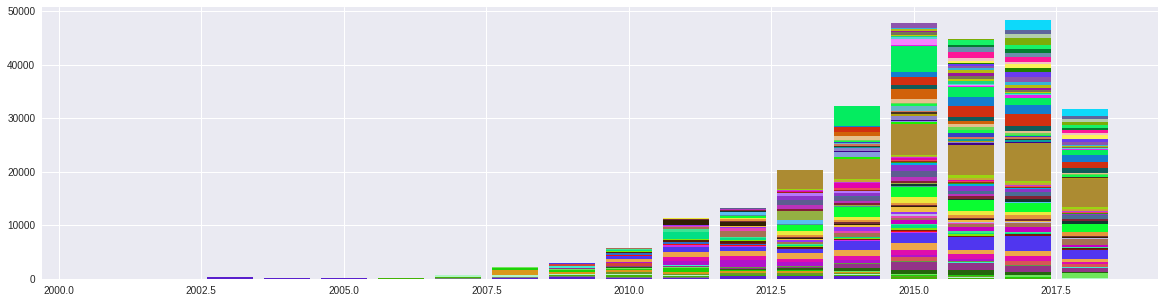

In [0]:
import random

plt.figure(figsize=(20,5))
level = np.zeros(len(counts[0]))
for i in range(len(counts)):
  color = '#'+format(random.randint(0, 16**6), '06x')
  plt.bar(years, counts[i], bottom=level, color=color)
  level = level + counts[i]

plt.show()

This graph is a little bit too noisy. Let's limit the graph to only the projects in the top 10 number of commits.

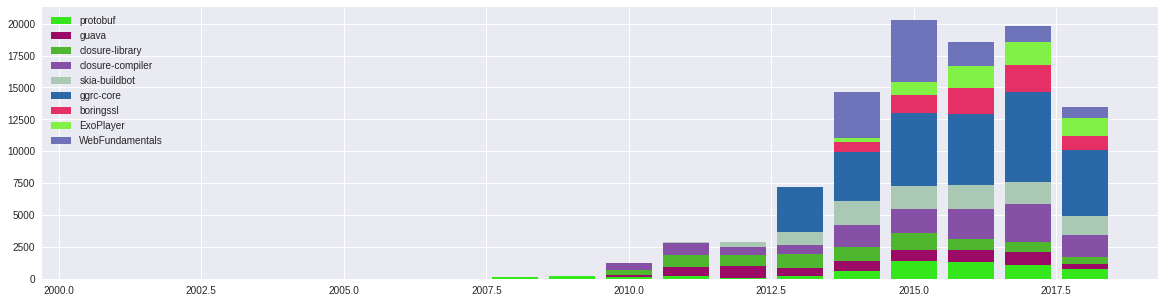

In [0]:
import random

plt.figure(figsize=(20,5))
level = np.zeros(len(counts[0]))
min = np.sort(np.sum(np.array(counts), axis=1))[-10]
(big_repos, big_counts) = zip(*[(repo, count) for (repo, count) in zip(repos, counts) if sum(count) > min])
for i in range(len(big_counts)):
  color = '#'+format(random.randint(0, 16**6), '06x')
  plt.bar(years, big_counts[i], bottom=level, color=color)
  level = level + big_counts[i]

plt.legend(big_repos)
plt.show()

It seems like while the work on boringssl started to slow down since 2015, but ggrc-core keeps on growing!

Counting files while keeping high performance requires using `JOIN`,
the following request is able to count how many files are there in each repository on `HEAD`.

In [0]:
(repos, counts) = zip(*run("""
SELECT f.repository_id, COUNT(*) as n
FROM   files AS f
       NATURAL JOIN commit_files cf
       NATURAL JOIN refs
WHERE  ref_name = 'HEAD'
GROUP BY f.repository_id
ORDER BY n DESC
"""))

2018-11-07 22:03:27 80ee19d41ee3 root[63] DEBUG done in 3.15 seconds


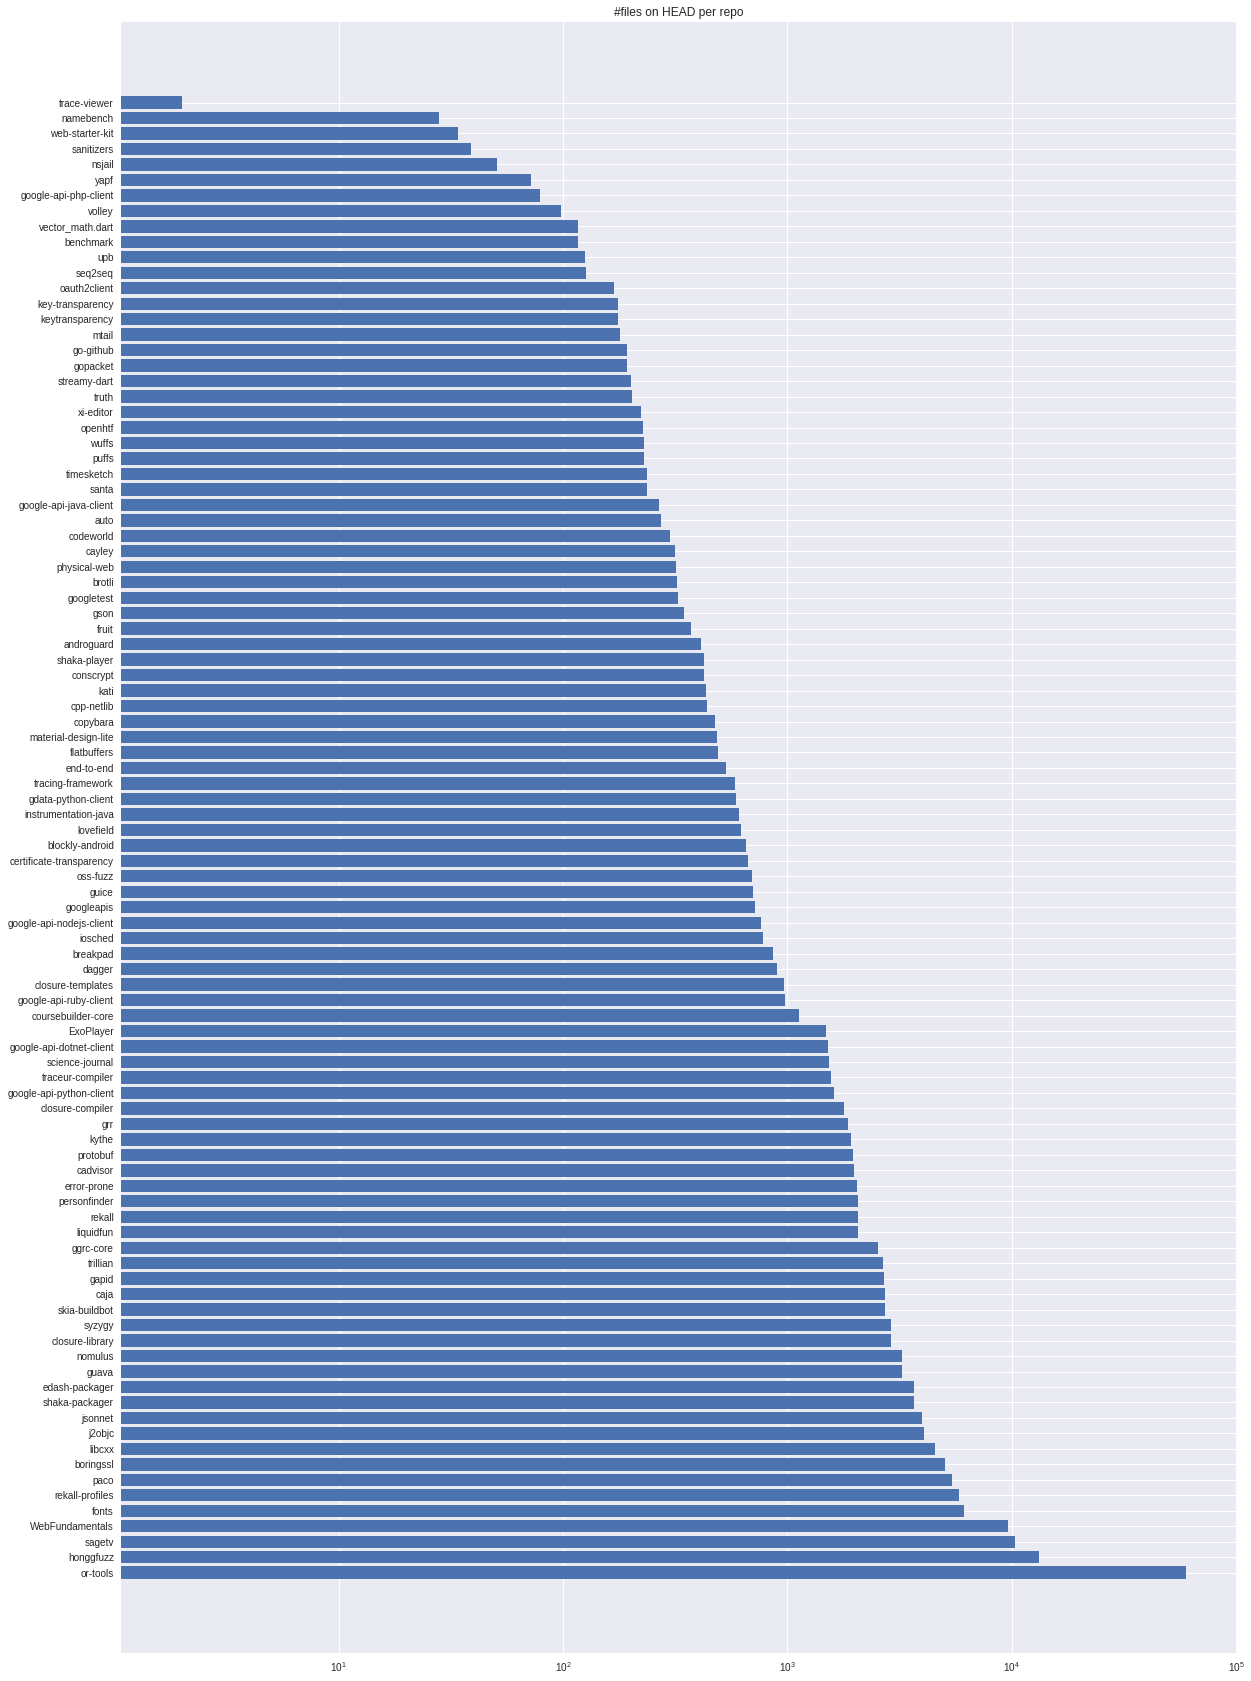

In [0]:
plt.figure(figsize=(20, 30))
plt.xscale('log')
plt.barh(range(len(counts)), counts, tick_label=repos)
plt.title('#files on HEAD per repo')
plt.show()

What about the commit message for the latest commit in each repository?

In [0]:
logging.info('loading data, will take a couple of seconds')

hashes = run("""
SELECT repository_id, MAX(history_index) as history_index, commit_hash
FROM ref_commits
WHERE ref_name = 'HEAD'
GROUP BY repository_id
""")

logging.info('showing only three repositories')

for (repo, _, hash) in list(hashes)[:3]:
    (msg,) = run_one("""
      SELECT commit_message
      FROM commits
      WHERE 
          repository_id = '%s' AND
          commit_hash = '%s'
    """ % (repo, hash))
    print('\n' + repo)
    print('=' * len(repo))
    print(msg)

2018-11-07 22:03:47 80ee19d41ee3 root[63] INFO loading data, will take a couple of seconds
2018-11-07 22:03:48 80ee19d41ee3 root[63] DEBUG done in 1.20 seconds
2018-11-07 22:03:48 80ee19d41ee3 root[63] INFO showing only three repositories
2018-11-07 22:03:49 80ee19d41ee3 root[63] DEBUG done in 0.07 seconds
2018-11-07 22:03:49 80ee19d41ee3 root[63] DEBUG done in 0.07 seconds



benchmark
Prevent GTest and GMock from being installed with Google Benchmark.

When users satisfy the GTest dependancy by placing a googletest
directory in the project, the targets from GTest and GMock incorrectly
get installed along side this library. We shouldn't be installing
our test dependancies.

This patch forces the options that control installation for googletest
to OFF.


brotli
Fix build instructions for cmake



2018-11-07 22:03:49 80ee19d41ee3 root[63] DEBUG done in 0.07 seconds



nsjail
README Docker disambiguations

Disambiguate between nsjail _container_ and _command_ in README for easier reading.

- Being a n00b to this project I feel this makes the onboarding of use with Docker somewhat easier by removing duplicated/overloaded terms.


### Analyzing contributor behavior

One of the pieces of information we can extract from a git repository is the identity of the contributor for each commit. Let's use that to try to track who's there. Let's start counting the number of contributors per repository!

2018-11-07 22:04:03 80ee19d41ee3 root[63] DEBUG done in 10.65 seconds


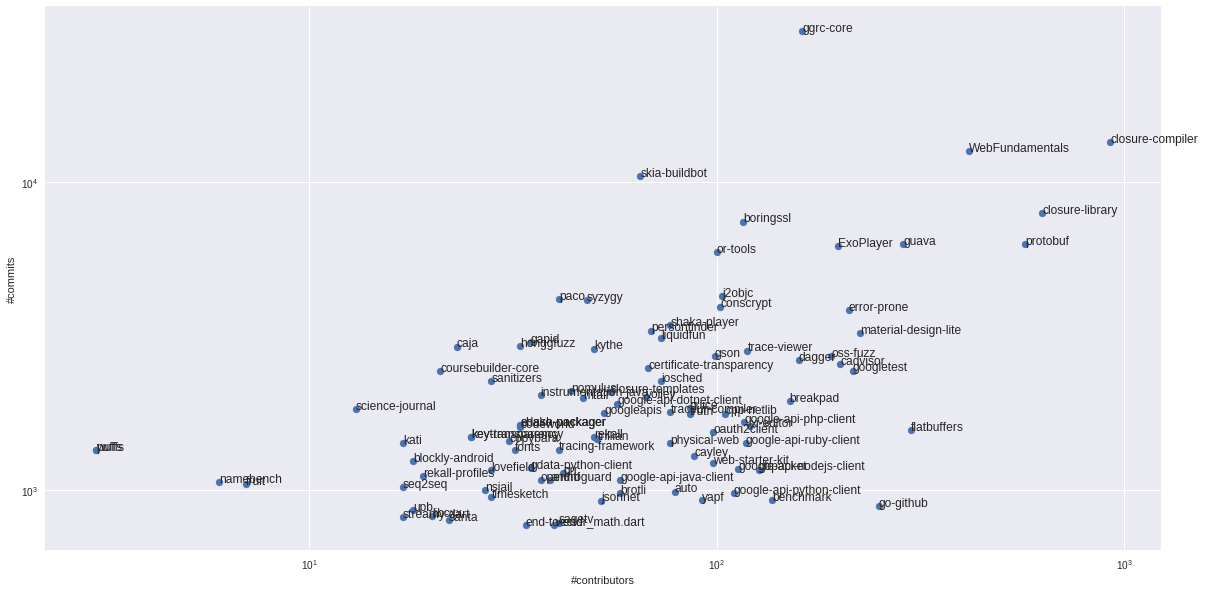

In [0]:
# difference between commit author and committer:
# https://stackoverflow.com/questions/6755824/what-is-the-difference-between-author-and-committer-in-git

rows = run("""
SELECT repository_id, SUM(commit_count) as commit_count, COUNT(*) as contributor_count
FROM (
  SELECT repository_id, commit_author_email, COUNT(*) as commit_count
  FROM commits
  GROUP BY repository_id, commit_author_email
) as t
GROUP BY repository_id;
""")


repos, commits, contributors = zip(*rows)

fig, s = plt.subplots(figsize=(20,10))
s.scatter(contributors, commits)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('#contributors'); plt.ylabel('#commits')
for i, repo in enumerate(repos):
    s.annotate(repo, (contributors[i], commits[i]))
plt.show()

This query allowed us to see that there's a clear (and expected) correlation between the number of contributors and number of contributions although some repositories have more productive contributors than others, for instance `ggrc-core` and `skia-buildbot` seem to have a really large number of contributions/contributor, while `go-github` seems to have more "one-off" contributions.

In [0]:
import operator

l = list(zip(repos, commits, contributors, np.array(commits)/np.array(contributors)))
l.sort(key=operator.itemgetter(3))

headers = '%30s % 10s % 10s %10s'  % ('repository', 'commits', 'contribs', 'ratio')
headers = '\n' + headers + '\n' + '-' * len(headers)
template = '%30s % 10d % 10d % 10.2f'

print('repos with most productive contributors:')
print(headers)
for r in l[:5]:
  print(template % r)

print('\nrepos with least productive contributors:')
print(headers)
for r in l[-5:]:
  print(template % r)


repos with most productive contributors:

                    repository    commits   contribs      ratio
---------------------------------------------------------------
                     go-github        887        250       3.55
                   flatbuffers       1565        300       5.22
                     benchmark        924        137       6.74
      google-api-python-client        976        110       8.87
                      gopacket       1163        127       9.16

repos with least productive contributors:

                    repository    commits   contribs      ratio
---------------------------------------------------------------
                 skia-buildbot      10443         65     160.66
                     namebench       1061          6     176.83
                     ggrc-core      30858        162     190.48
                         puffs       1348          3     449.33
                         wuffs       1348          3     449.33


Tunrns out both `go-github` has only around 3.5 contributions per contributor, which points in the direction of a repository where many people contribute once and go away.

On the other hand, `wuffs` and `puffs` have only three contributors that are incredibly prolific!

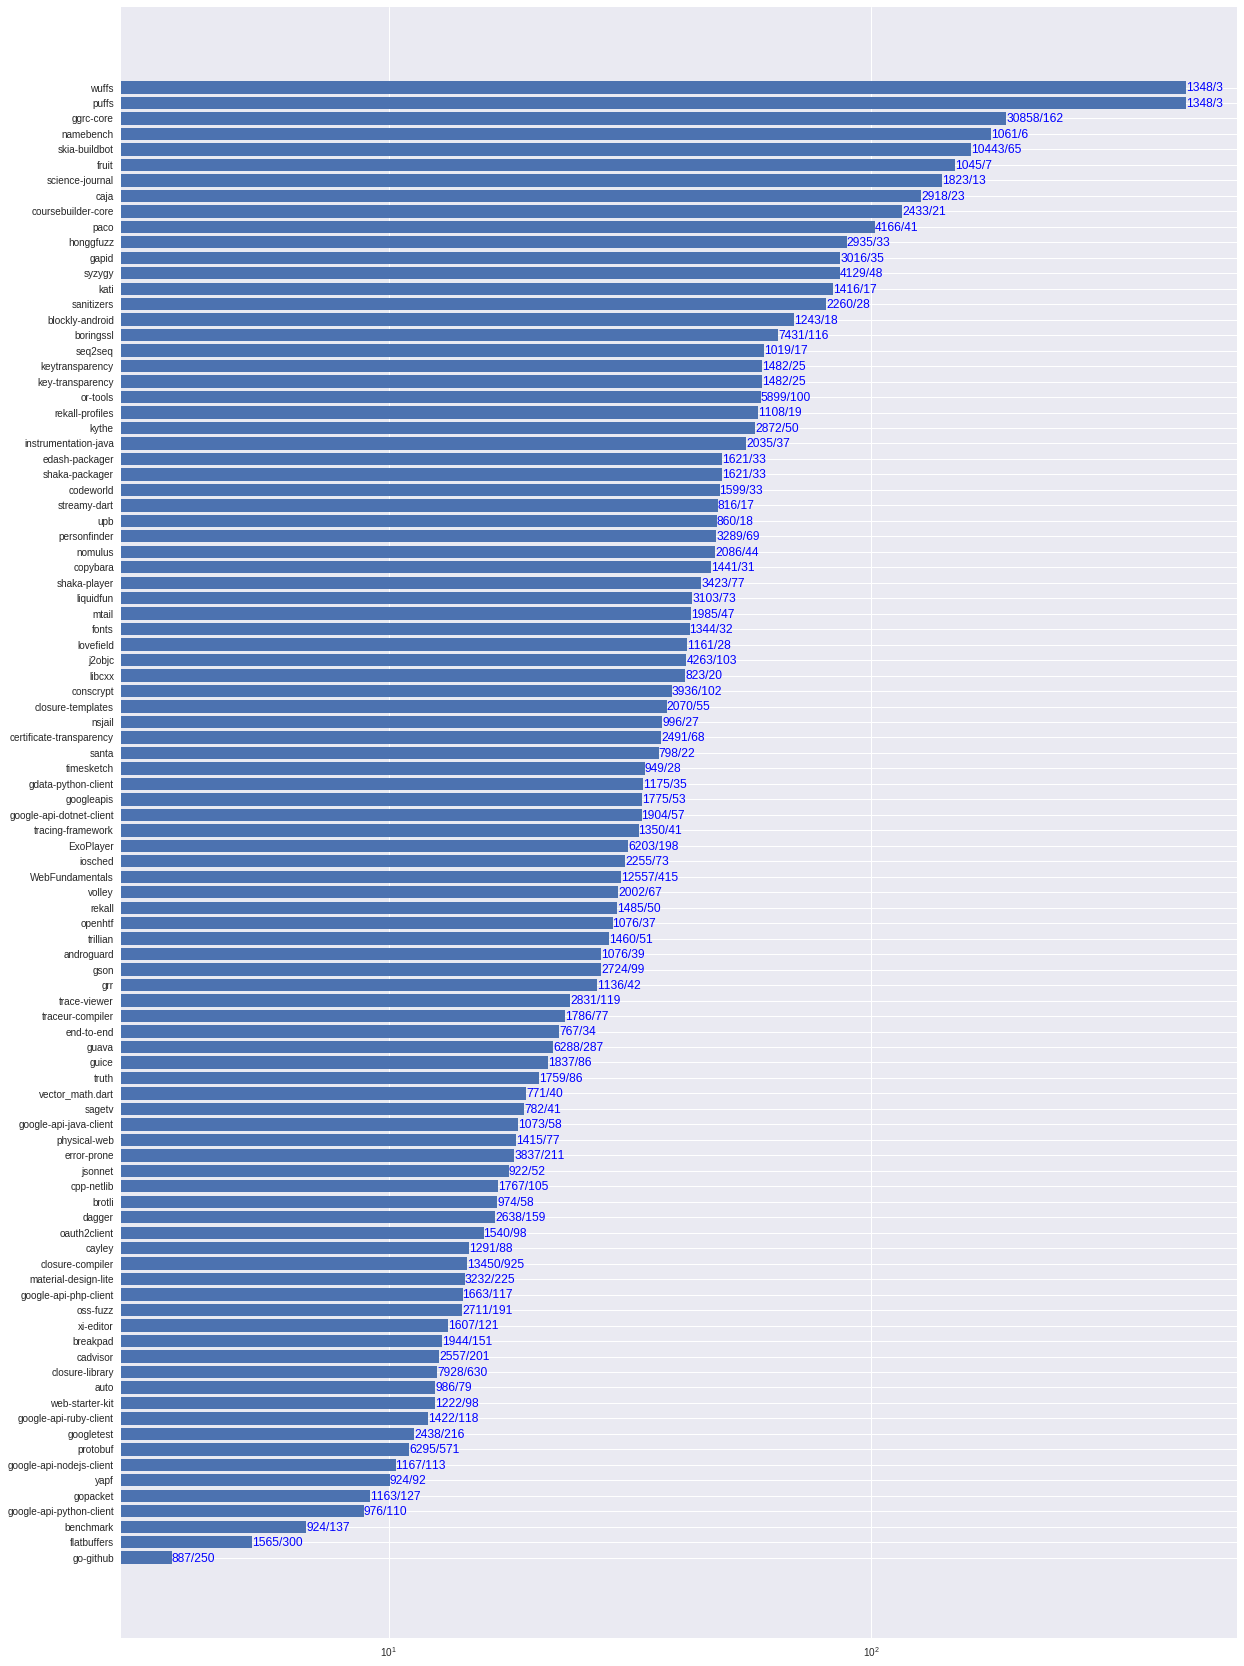

In [0]:
(repos, commits, contributors, ratios) = zip(*l)
fig, s = plt.subplots(figsize=(20,30))
x = np.arange(len(l))
plt.barh(x, ratios)
plt.xscale('log')
plt.yticks(x, repos)

for (i, repo) in enumerate(repos):
    s.text(ratios[i], i-0.25, '%d/%d' % (commits[i], contributors[i]), color='blue')

plt.show()

Great, this allows us to easily identify which repositories have the most engaged contributors. But how many of those contributors contribute to more than one of these projects? Let's see that now!

In [0]:
emails, repos, commits = zip(*run("""
  SELECT commit_author_email, COUNT(*) as repos_count, SUM(commit_count) as commit_count
  FROM (
    SELECT repository_id, commit_author_email, COUNT(*) as commit_count
    FROM commits
    GROUP BY repository_id, commit_author_email
  ) as t
  GROUP BY commit_author_email;
"""))

2018-11-07 22:04:27 80ee19d41ee3 root[63] DEBUG done in 10.92 seconds


/usr/local/lib/python3.6/dist-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


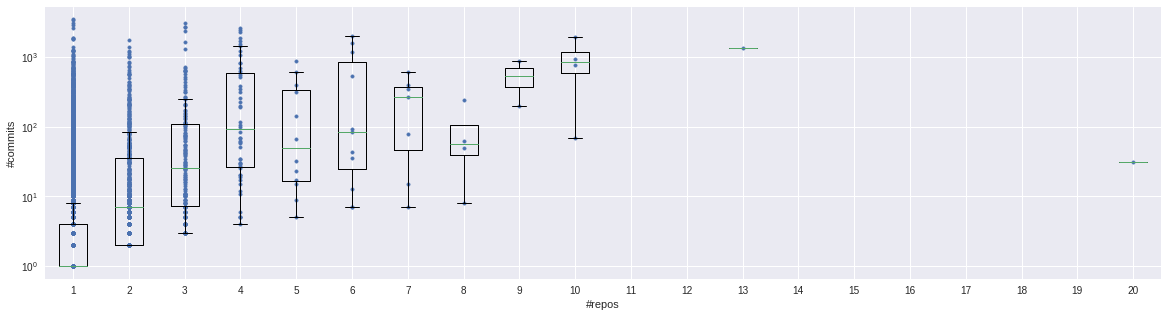

In [0]:
buckets = np.arange(np.min(repos), np.max(repos)+1)
data = [[c for (i, c) in enumerate(commits) if repos[i] == bucket] for bucket in buckets]
fig, s = plt.subplots(figsize=(20,5))
s.scatter(repos, commits, marker='.')
s.boxplot(data, boxprops=dict(color='k'))
plt.yscale('log')
plt.xlabel('#repos')
plt.ylabel('#commits')
plt.show()

It is clear that there's a correlation: contributors that contribute more tend to contribute to a larger number of repositories.

But it's important to point out that many contributors that participate in a single repository might still be incredibly prolific as the many ouliers on the first column show.



### Detecting languages

Once we have all the files in a repository we can easily find the corresponding blob and classify the language it was written in by using the `LANGUAGE` custom function.

`LANGUAGE` receives two parameters: the file path and its content.

In [0]:
langs, counts = zip(*run("""
SELECT lang, COUNT(*) as n
FROM (
    SELECT LANGUAGE(cf.file_path, f.blob_content) as lang
    FROM   files AS f
           NATURAL JOIN commit_files cf
           NATURAL JOIN refs
    WHERE  ref_name = 'HEAD'
) AS t
WHERE lang is not null
GROUP BY lang
ORDER BY 2 DESC
"""))

2018-11-07 22:04:40 80ee19d41ee3 root[63] DEBUG done in 5.86 seconds


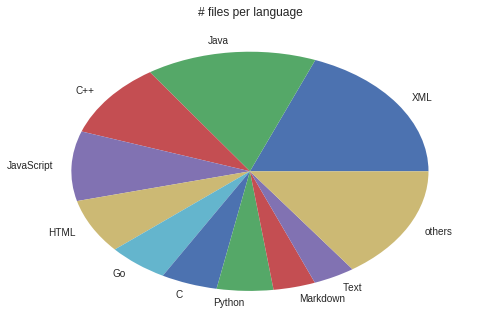

In [0]:
percents = [(100*c)/sum(counts) for c in counts if c/sum(counts) > 0.02]
if len(percents) < len(langs):
    percents.append(100 - sum(percents))
    langs = langs[:len(percents)-1] + ('others',)

plt.title('# files per language')
plt.pie(percents, labels=langs)
plt.show()

What about the number of lines of code?

In [0]:
logging.info('loading data, will take a couple of seconds')

langs, counts = zip(*run("""
SELECT lang, SUM(n)
FROM (
    SELECT lang, SUM(lines) as n
    FROM (
        SELECT f.repository_id, LANGUAGE(cf.file_path, f.blob_content) as lang,
               ARRAY_LENGTH(SPLIT(f.blob_content, '\n')) as lines
        FROM   files AS f
               NATURAL JOIN commit_files cf
               NATURAL JOIN refs
        WHERE  ref_name = 'HEAD'
    ) AS t
    WHERE lang IS NOT NULL
    GROUP BY repository_id, lang
) AS t
GROUP by lang
ORDER BY n DESC
"""))

2018-11-08 00:09:00 80ee19d41ee3 root[63] INFO loading data, will take a couple of seconds
2018-11-08 00:09:15 80ee19d41ee3 root[63] DEBUG done in 15.17 seconds


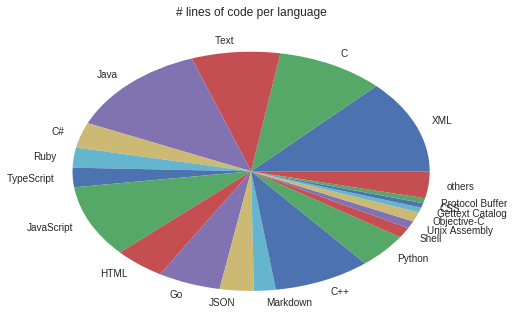

In [0]:
percents = [(100*c)/sum(counts) for c in counts if c/sum(counts) > 0.005]
if len(percents) < len(langs):
    percents.append(100 - sum(percents))
    langs = langs[:len(percents)-1] + ('others',)

plt.title('# lines of code per language')
plt.pie(percents, labels=langs)
plt.show()

And last but not least, what files tend to be longer?

In [0]:
langs, files, lines = zip(*run("""
SELECT lang, files, lines
FROM (
    SELECT lang, COUNT(*) as files, SUM(lines) as lines
    FROM (
        SELECT f.repository_id, LANGUAGE(cf.file_path, f.blob_content) as lang,
               ARRAY_LENGTH(SPLIT(f.blob_content, '\n')) as lines
        FROM   files AS f
               NATURAL JOIN commit_files cf
               NATURAL JOIN refs
        WHERE  ref_name = 'HEAD'
    ) AS t
    WHERE lang IS NOT NULL
    GROUP BY lang
) AS t
WHERE files > 10
ORDER BY lang
"""))

2018-11-08 00:10:24 80ee19d41ee3 root[63] DEBUG done in 11.77 seconds


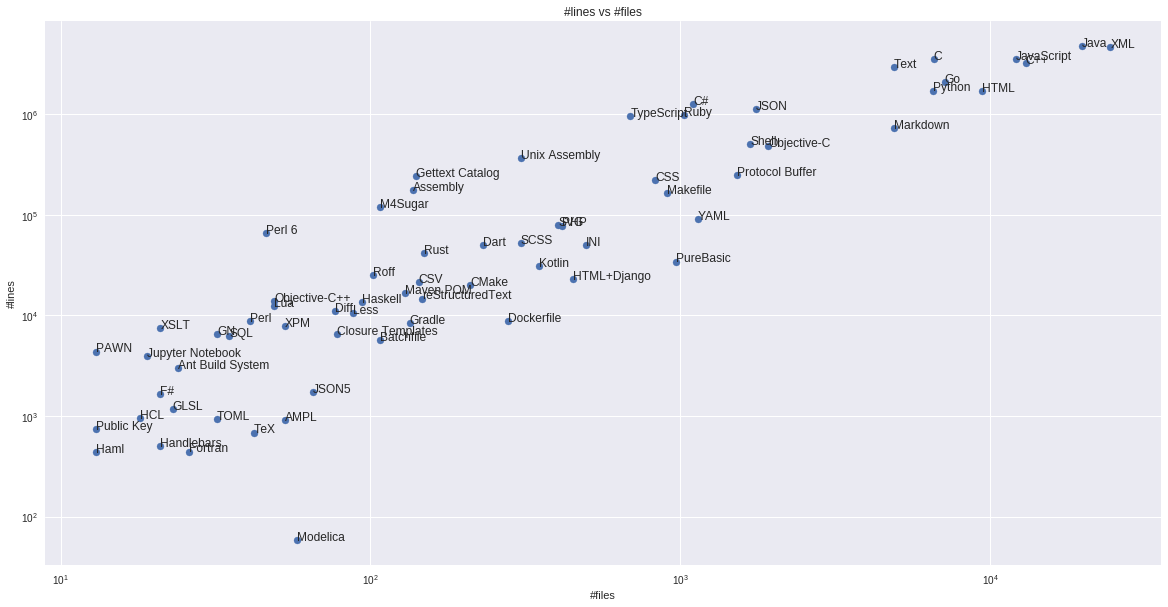

In [0]:
fig, s = plt.subplots(figsize=(20,10))
s.scatter(files, lines)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('#files'); plt.ylabel('#lines')
for i, lang in enumerate(langs):
    s.annotate(lang, (files[i], lines[i]))

plt.title('#lines vs #files')
plt.show()

In [0]:
import operator

l = list(zip(langs, lines, files, np.array(lines)/np.array(files)))
l.sort(key=operator.itemgetter(3))

headers = '%30s % 10s % 10s %10s'  % ('langs', 'lines', 'files', 'ratio')
headers = '\n' + headers + '\n' + '-' * len(headers)
template = '%30s % 10d % 10d % 10.2f'

print('languages with longer files:')
print(headers)
for r in l[:10]:
  print(template % r)

print('\nlanguages with shorter files:')
print(headers)
for r in l[-10:]:
  print(template % r)


languages with longer files:

                         langs      lines      files      ratio
---------------------------------------------------------------
                      Modelica         58         58       1.00
                           TeX        684         42      16.29
                       Fortran        443         26      17.04
                          AMPL        907         53      17.11
                    Handlebars        501         21      23.86
                         JSON5       1736         65      26.71
                          TOML        936         32      29.25
                    Dockerfile       8866        278      31.89
                          Haml        435         13      33.46
                     PureBasic      34311        965      35.56

languages with shorter files:

                         langs      lines      files      ratio
---------------------------------------------------------------
                          Text    2944254 

Those 46 Perl 6 files containing over 65k lines of code has to be a fun place to work!

## Parsing and extracting from source code

After understanding the `LANGUAGE` function it's time to present `UAST`. This function receives two parameters:
- the language to be parsed
- the content of the file to be parsed

Let's give it a try and parse some of the files.

In [0]:
print("""
  SELECT LANGUAGE(f.file_path, f.blob_content) AS lang,
         UAST(f.blob_content, LANGUAGE(cf.file_path, f.blob_content), '//FunctionGroup/Alias/Identifier') as uast
  FROM   files AS f
         NATURAL JOIN commit_files cf
         NATURAL JOIN refs
  WHERE  ref_name = 'HEAD' AND
         f.blob_content IS NOT NULL AND
         lang IN %s
  LIMIT  10
 """ % languages)


  SELECT LANGUAGE(f.file_path, f.blob_content) AS lang,
         UAST(f.blob_content, LANGUAGE(cf.file_path, f.blob_content), '//FunctionGroup/Alias/Identifier') as uast
  FROM   files AS f
         NATURAL JOIN commit_files cf
         NATURAL JOIN refs
  WHERE  ref_name = 'HEAD' AND
         f.blob_content IS NOT NULL AND
         lang IN ('Python', 'Java', 'Go', 'PHP')
  LIMIT  10
 


In [0]:
 # extract function names from all files

# languages = "('Python', 'Java', 'JavaScript', 'TypeScript', 'Bash', 'Ruby', 'Go', 'PHP')"
languages = "('Python', 'Java', 'Go', 'PHP')"
langs, lists = zip(*run("""
  SELECT LANGUAGE(f.file_path, f.blob_content) AS lang,
         UAST_EXTRACT(UAST(f.blob_content, LANGUAGE(cf.file_path, f.blob_content), '//FunctionGroup/Alias/Identifier'), 'Name') as uast
  FROM   files AS f
         NATURAL JOIN commit_files cf
         NATURAL JOIN refs
  WHERE  ref_name = 'HEAD' AND
         f.blob_content IS NOT NULL AND
         lang IN %s
 """ % languages))

In [0]:
import ast
from wordcloud import WordCloud

parsed = [[] if x == 'null' else ast.literal_eval(x) for x  in lists]
pairs = [(lang, func) for (fs, lang) in zip(parsed, langs) for func in fs ]
(langs, funcs) = zip(*pairs)

freqs = {}
for func in funcs:
  freqs[func] = freqs.get(func, 0)+1
wordcloud = WordCloud().generate_from_frequencies(freqs)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

SyntaxError: ignored

What if we used the function names in each function to identify the language? Let's play!

Python


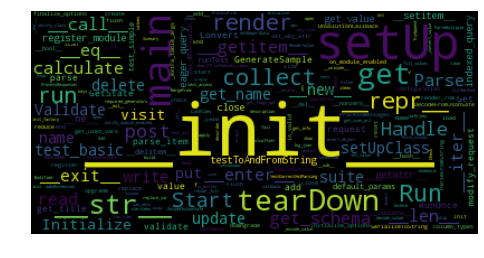

Go


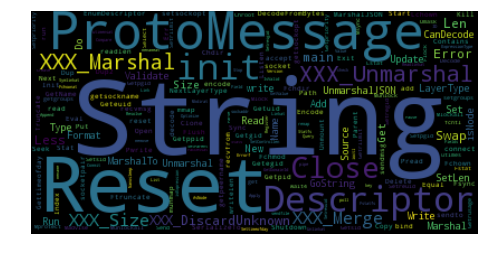

Java


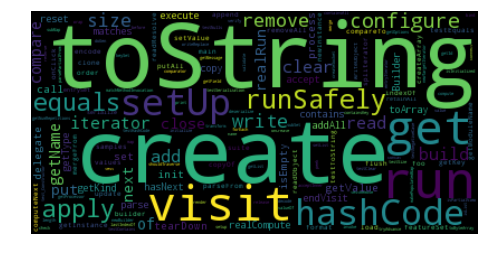

PHP


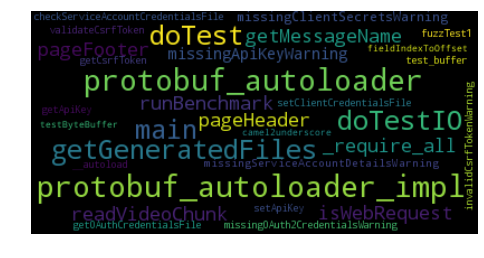

In [0]:
import ast
from wordcloud import WordCloud

freq_langs = {}
for (lang, func) in pairs:
  freqs = freq_langs.get(lang, {})
  freqs[func] = freqs.get(func, 0)+1
  freq_langs[lang] = freqs

  
for lang in freq_langs:
  # uncomment this to show what language is which
  print(lang)
  wordcloud = WordCloud().generate_from_frequencies(freq_langs[lang])
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()